In [1]:
%matplotlib notebook
import time
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas
import cv2
from scipy.ndimage.filters import gaussian_filter1d
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from speed_regression import training_data as td
from speed_regression import regression
from speed_regression import regression_cascade

nano_to_sec = 1e09

fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 8

In [2]:
option = td.TrainingDataOption()
extra_args = {'feature_smooth_sigma': 2.0,
              'target_smooth_sigma': 30.0}
imu_columns = ['gyro_x', 'gyro_y', 'gyro_z', 'linacce_x', 'linacce_y', 'linacce_z']

feature_dim = 1200
sv_type = {'names': ['f{}'.format(i) for i in range(feature_dim)],
           'formats': feature_dim * [np.float32]}

In [4]:
model_path = '../../models/svr_cascade0928_c1e001'
model = regression_cascade.load_model_from_file(model_path)
class_map = model.class_map

In [5]:
# Get the supporting vectors of regressors
sv_weights = [[] for _ in range(model.num_classes)]
sv_vectors = [[] for _ in range(model.num_classes)]
for cls in range(model.num_classes):
    for chn in range(model.num_channels):
        reg = model.regressors[cls * model.num_channels + chn]
        _, sv_w, _ = reg.getDecisionFunction(0)
        sv_weights[cls].append(sv_w.ravel())
        sv_vectors[cls].append(reg.getSupportVectors())

In [6]:
# Redefine the load_datalist routine that returns the index of each sample in the whole training set.
def load_datalist_with_global_index(path):
    responses = []
    # global_index stores a tuple for each sample: (dataset_index, index_inside_dataset)
    global_index = []
    class_index = [[] for _ in range(len(class_map))]
    features = [[] for _ in range(len(class_map))]
    dataset_names = []
    root_dir = os.path.dirname(path)
    with open(path) as f:
        dataset_list = [s.strip('\n') for s in f.readlines()]
    for dataset in dataset_list:
        if len(dataset) > 0 and dataset[0] == '#':
            continue
        info = dataset.split(',')
        if len(info) != 2:
            warnings.warn('{} has the wrong format. Skip'.format(info[0]))
        if info[1] not in class_map:
            warnings.warn('Class {} not in the class map. Skip'.format(info[1]))
        data_path = root_dir + '/' + info[0] + '/processed/data.csv'
        if not os.path.exists(data_path):
            warnings.warn('File ' + data_path + ' does not exist. Skip')
        data_all = pandas.read_csv(data_path)
        feat, resp = td.get_training_data(data_all=data_all, imu_columns=imu_columns, 
                                          option=option, extra_args=extra_args)
        ts = data_all['time'].values / nano_to_sec
        dataset_names.append(info[0])
        global_index += [(len(responses), i) for i in range(resp.shape[0])]
        class_index[class_map[info[1]]] += [(len(responses), i) for i in range(resp.shape[0])]
        features[class_map[info[1]]].append(feat)
        responses.append(resp[:, [0, 2]])
        print('Dataset ' + data_path + ' loaded')
    for i in range(len(features)):
        features[i] = np.concatenate(features[i], axis=0)
    return features, responses, global_index, class_index, dataset_names

In [19]:
# Exact match. This is too slow.
# @jit
def get_sv_index(sv, training_features):
    sv_index = np.empty(sv.shape[0], dtype=np.int)
    sv_view = sv.view(sv_type)
    feature_view = training_features.astype(np.float32).view(sv_type)
    for i in range(sv.shape[0]):
        ind = np.where(feature_view == sv_view[i])
        sv_index[i], _ = np.where(feature_view == sv_view[i])
    return sv_index

In [7]:
# Only compare the sum of the vector
# @jit
def simple_sum_vectorization(input, bin_size=10):
    kbin = int(input.shape[1] / bin_size)
    vectorized = np.empty([input.shape[0], kbin])
    for i in range(kbin):
        vectorized[:, i] = np.sum(input[:, bin_size*i:bin_size*(i+1)], axis=1)
    return vectorized
def get_sv_index_fast(sv, training_features):
    sv_index = np.empty(sv.shape[0], dtype=np.int)
    sv_sum = simple_sum_vectorization(sv, 120)
    feature_sum = simple_sum_vectorization(training_features, 120)
    for i in range(sv_sum.shape[0]):
        sv_index[i] = np.argmin(np.sum(np.fabs(feature_sum - sv_sum[i]), axis=1))
    return sv_index

In [8]:
# load testing data
features, responses, global_index, class_index, names = load_datalist_with_global_index('../../data2/list_train_3sub.txt')

Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Dataset ../../data2/hang_handheld_normal1/processed/data.csv loaded
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Dataset ../../data2/hang_handheld_speed1/processed/data.csv loaded
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Dataset ../../data2/hang_handheld_side1/processed/data.csv loaded
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Dataset ../../data2/hang_handheld_spin1/processed/data.csv loaded
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Dataset ../../data2/hang_leg_normal1/processed/data.csv loaded
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Dataset ../../data2/hang_leg_speed1/processed/data.csv loaded
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter

In [9]:
sv_indices = [[] for _ in class_map]
for cls in range(len(class_map)):
    for chn in range(len(sv_vectors[cls])):
        print('class {}, chn {}'.format(cls, chn))
        sv_indices[cls].append(get_sv_index_fast(sv_vectors[cls][chn], features[cls]))

class 0, chn 0
class 0, chn 1
class 1, chn 0
class 1, chn 1
class 2, chn 0
class 2, chn 1
class 3, chn 0
class 3, chn 1


<IPython.core.display.Javascript object>


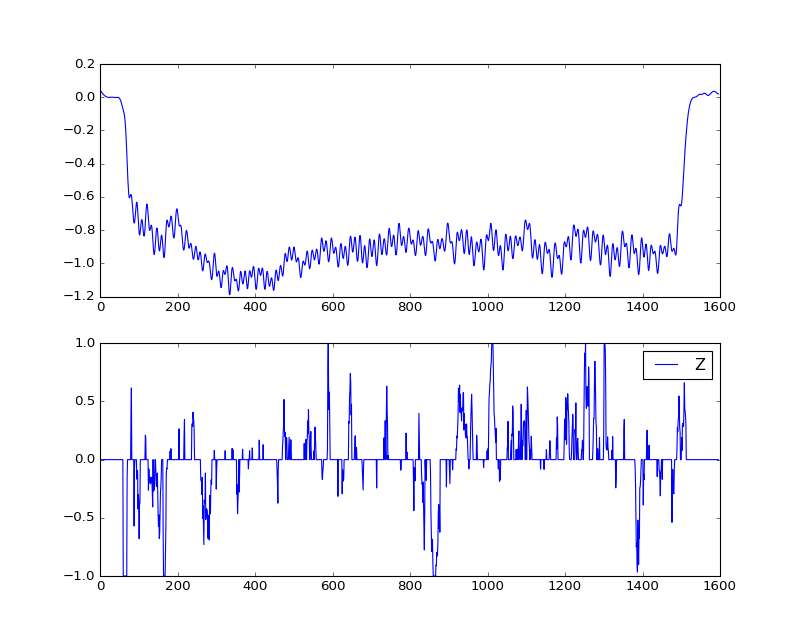

<IPython.core.display.Javascript object>


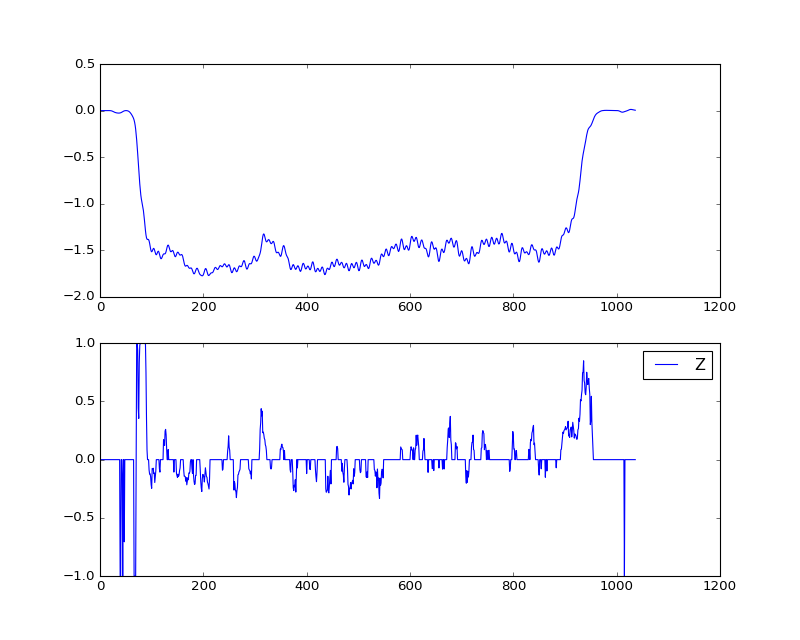

<IPython.core.display.Javascript object>


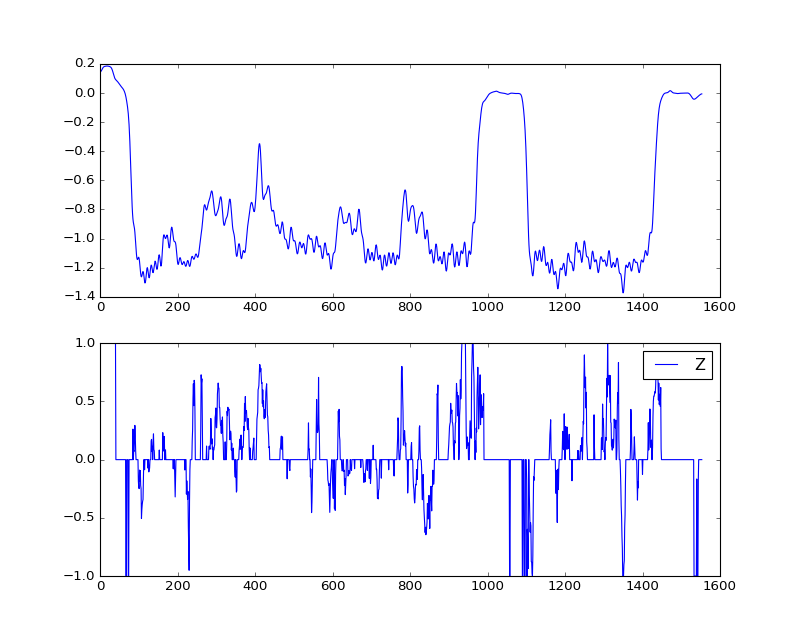

<IPython.core.display.Javascript object>


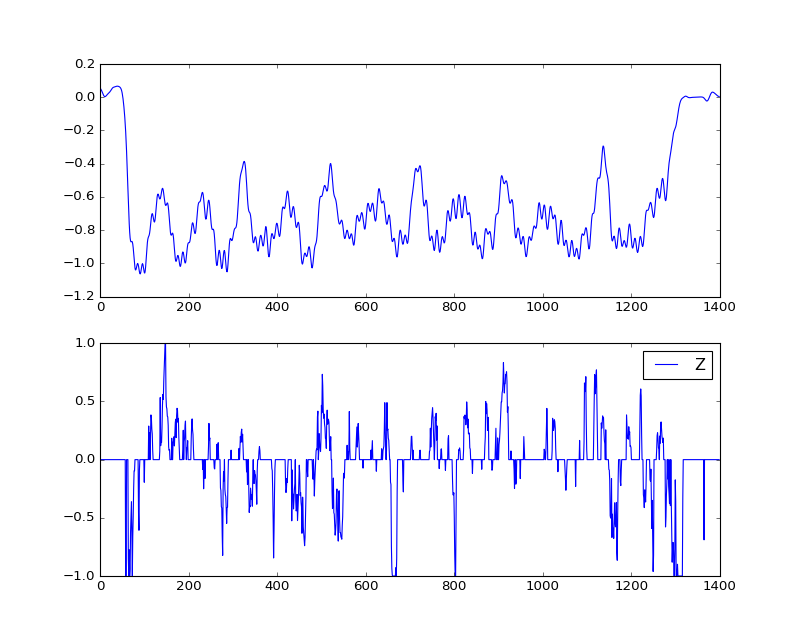

<IPython.core.display.Javascript object>


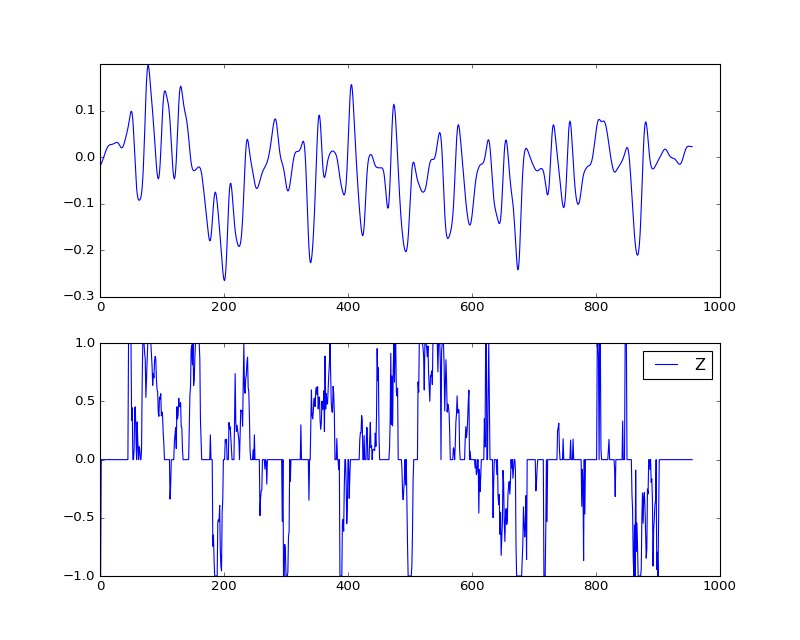

<IPython.core.display.Javascript object>


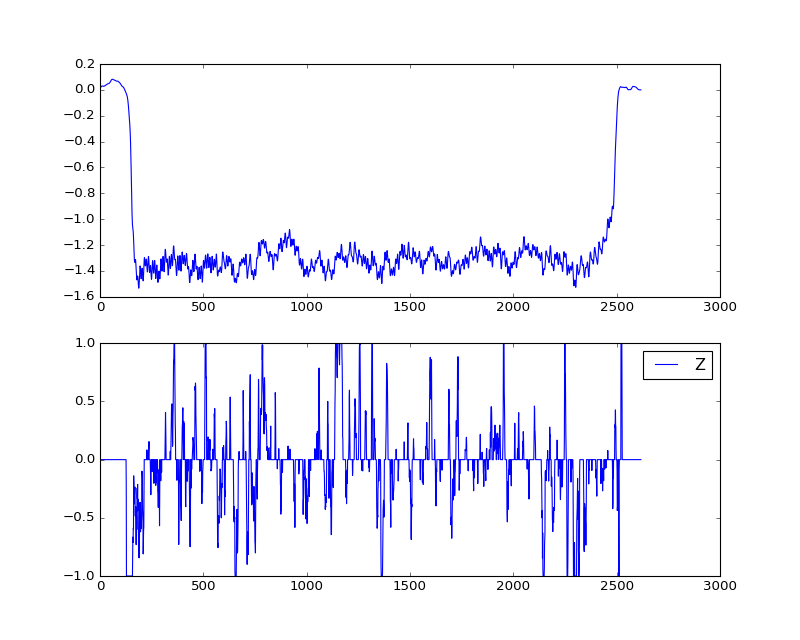

<IPython.core.display.Javascript object>


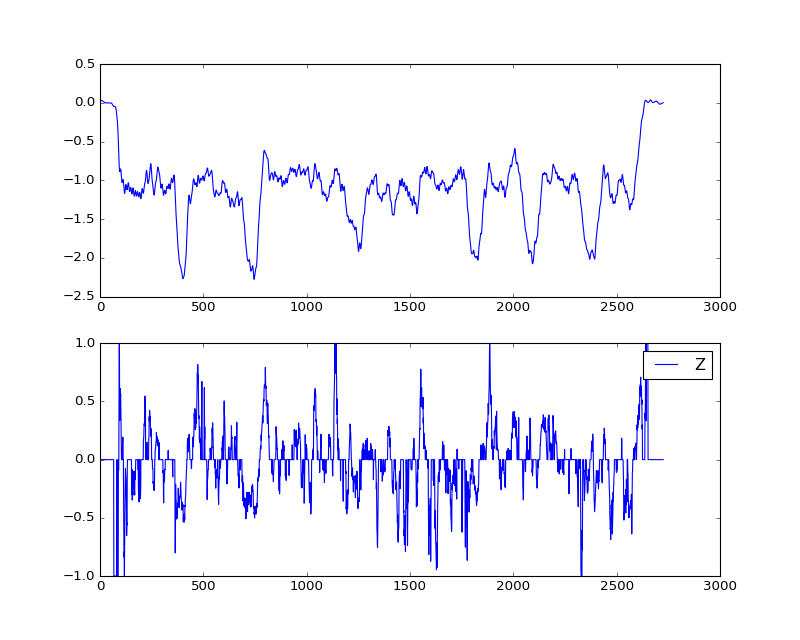

<IPython.core.display.Javascript object>


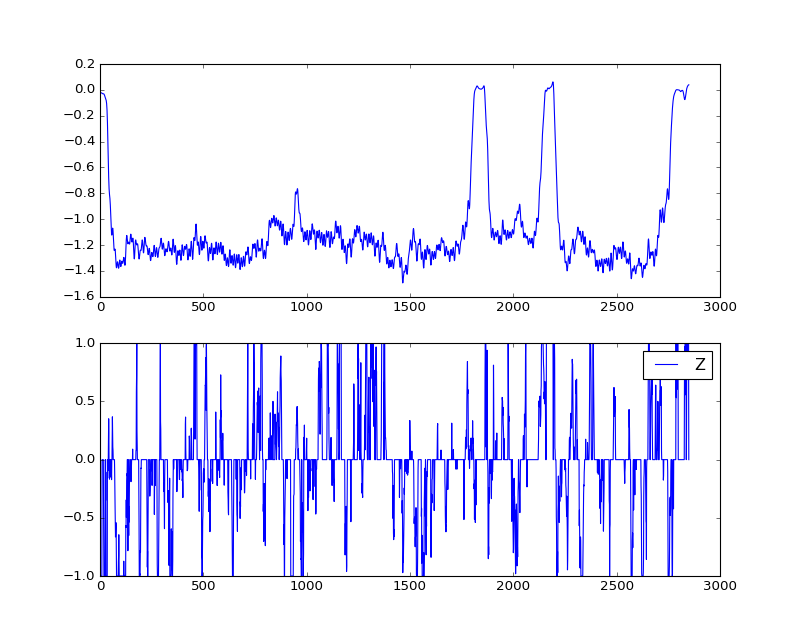

In [17]:
# plot the supporting vector weight of each regressor alongside the responses
class_name = 'body'
test_class = class_map[class_name]
dataset_in_class = set([t[0] for t in class_index[test_class]])
# Aggregate by the dataset index
sv_weight_datasets = {}
for data_id in dataset_in_class:
    sv_weight_datasets[data_id] = np.zeros(responses[data_id].shape)
for chn in range(len(sv_indices[test_class])):
    for i in range(sv_indices[test_class][chn].ravel().shape[0]):
        ind =  sv_indices[test_class][chn][i]
        index_in_dataset = class_index[test_class][ind]
        sv_weight_datasets[index_in_dataset[0]][index_in_dataset[1], chn] = sv_weights[test_class][chn][i]
        
for data_id in dataset_in_class:
    plt.figure('Class {}, dataset {}'.format(class_name, names[data_id]))
    plt.subplot(211)
    plt.plot(responses[data_id][:, 1])
    plt.subplot(212)
    plt.plot(sv_weight_datasets[data_id][:, 1])
    plt.legend(['Z'])

In [59]:
# Plot the supporting vector of the classifier
sv_classifier = model.classifier.getSupportVectors()
kclass = model.num_classes
test_function = 0
_, sv_weight_classifier, _ = model.classifier.getDecisionFunction(test_function)
sv_weight_classifier = sv_weight_classifier.ravel()
print('kSV for function {}: {}'.format(test_function, sv_weight_classifier.shape))

sv_weights_datasets = [np.zeros([res.shape[0]]) for res in responses]
features_all = np.concatenate(features, axis=0)

features_all_sum = simple_sum_vectorization(features_all, 120)
sv_sum = simple_sum_vectorization(sv_classifier, 120)

print(sv_sum.shape)
for i in range(sv_sum.shape[0]):
    global_ind = np.argmin(np.sum(np.fabs(features_all_sum - sv_sum[i]), axis=1))
    dataset_ind = global_index[global_ind]
    sv_weights_datasets[dataset_ind[0]][dataset_ind[1]] = sv_weight_classifier[i]

for i in range(sv_weights_datasets):
    plt.figure(names[i])
    plt.plot(responses[i][:, 1])
    plt.plot(sv_weights_datasets[i])

kSV for function 0: (3928,)
(9266, 10)


KeyboardInterrupt: 